<a href="https://colab.research.google.com/github/Kirantamilselvan/datastore/blob/main/DiabeticRetinopathyCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
import os
print('CWD is ',os.getcwd())
import multiprocessing
from multiprocessing.pool import ThreadPool
# Vis Libs..
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["axes.grid"] = False


from PIL import Image
import cv2


import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator,img_to_array,array_to_img,load_img
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
from keras.callbacks import EarlyStopping,ReduceLROnPlateau


from sklearn.model_selection import train_test_split


CWD is  /content


#Exporatory ImageData Analysis

In [ ]:
def load_data():
    train = pd.read_csv('/content/drive/MyDrive/train.csv')
    test = pd.read_csv('/content/drive/MyDrive/test.csv')

    train_dir = os.path.join('./', '/content/drive/MyDrive/train_images/')
    test_dir = os.path.join('./', '/content/drive/MyDrive/test_images/')

    train['file_path'] = train['id_code'].map(lambda x: os.path.join(train_dir, '{}.png'.format(x)))
    test['file_path'] = test['id_code'].map(lambda x: os.path.join(test_dir, '{}.png'.format(x)))

    train['file_name'] = train["id_code"].apply(lambda x: x + ".png")
    test['file_name'] = test["id_code"].apply(lambda x: x + ".png")

    train['diagnosis'] = train['diagnosis'].astype(str)

    return train, test

In [ ]:
df_train,df_test = load_data()
print(df_train.shape,df_test.shape,'\n')

df_train.head(6)

(3662, 4) (1928, 3) 



,id_code,diagnosis,file_path,file_name
0,000c1434d8d7,2,/content/drive/MyDrive/train_images/000c1434d8...,000c1434d8d7.png
1,001639a390f0,4,/content/drive/MyDrive/train_images/001639a390...,001639a390f0.png
2,0024cdab0c1e,1,/content/drive/MyDrive/train_images/0024cdab0c...,0024cdab0c1e.png
3,002c21358ce6,0,/content/drive/MyDrive/train_images/002c21358c...,002c21358ce6.png
4,005b95c28852,0,/content/drive/MyDrive/train_images/005b95c288...,005b95c28852.png
5,0083ee8054ee,4,/content/drive/MyDrive/train_images/0083ee8054...,0083ee8054ee.png


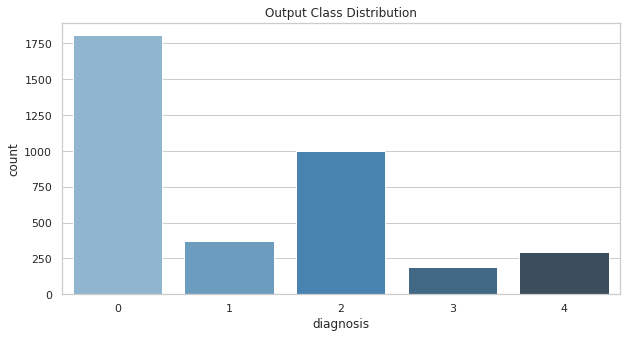

In [ ]:
def plot_classes(df):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution')
    plt.show()


plot_classes(df_train)

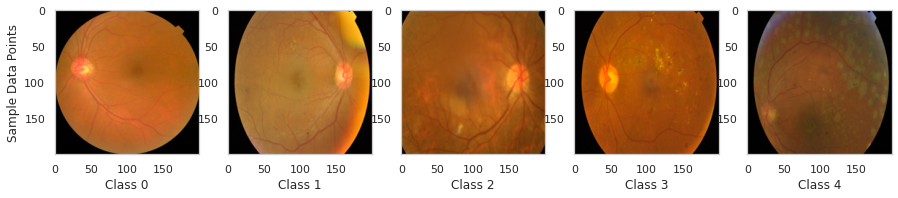

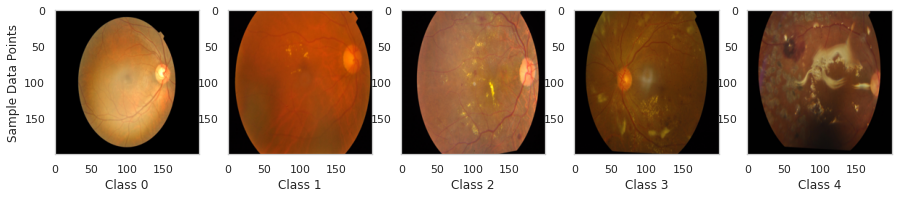

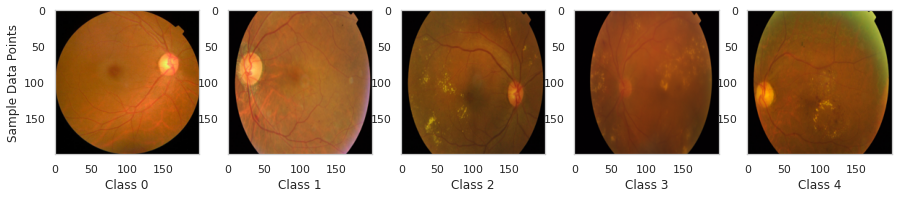

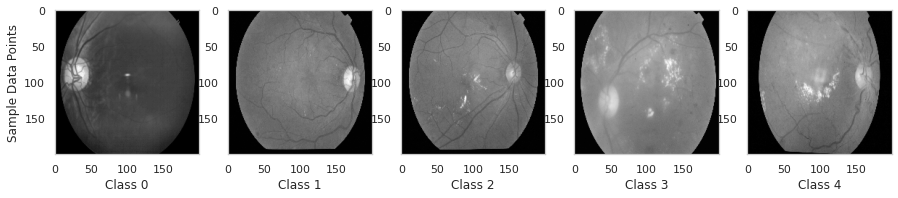

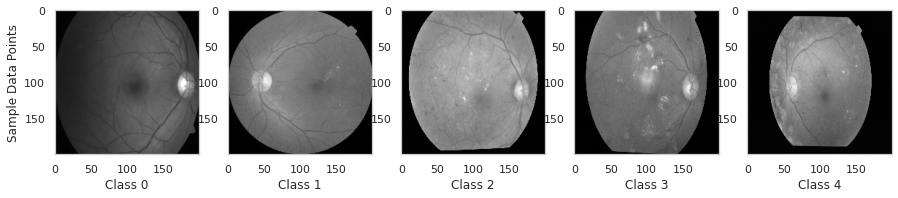

In [ ]:
IMG_SIZE = 200


def conv_gray(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    return img





def visualize_imgs(df, pts_per_class, color_scale):
    df = df.groupby('diagnosis', group_keys=False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop=True)

    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1, 5, figsize=(15, 15))
        axarr[0].set_ylabel("Sample Data Points")

        df_temp = df[df.index.isin(
            [pt + (pts_per_class * 0), pt + (pts_per_class * 1), pt + (pts_per_class * 2), pt + (pts_per_class * 3),
             pt + (pts_per_class * 4)])]
        for i in range(5):
            if color_scale == 'gray':
                img = conv_gray(cv2.imread(df_temp.file_path.iloc[i]))
                axarr[i].imshow(img, cmap=color_scale)
            else:
                axarr[i].imshow(Image.open(df_temp.file_path.iloc[i]).resize((IMG_SIZE, IMG_SIZE)))
            axarr[i].set_xlabel('Class ' + str(df_temp.diagnosis.iloc[i]))

        plt.show()

visualize_imgs(df_train,3,color_scale = None)

visualize_imgs(df_train,2,color_scale = 'gray')

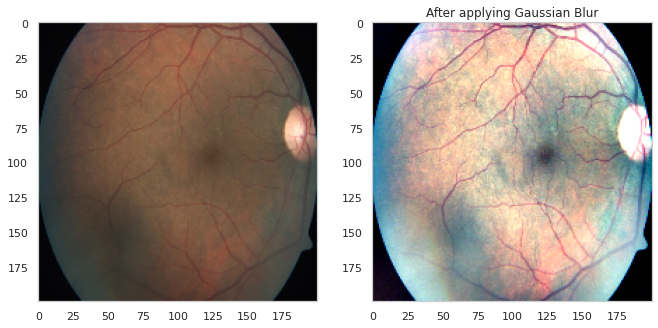

In [ ]:


rn = np.random.randint(low = 0,high = len(df_train) - 1)

img = cv2.imread(df_train.file_path.iloc[rn])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))

img_t = cv2.addWeighted(img,4, cv2.GaussianBlur(img , (0,0) , 30) ,-4 ,128)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(img)
axarr[1].imshow(img_t)
plt.title('After applying Gaussian Blur')
plt.show()

In [ ]:



def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img
    
    
def circle_crop(img, sigmaX):   
    
    
  
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img

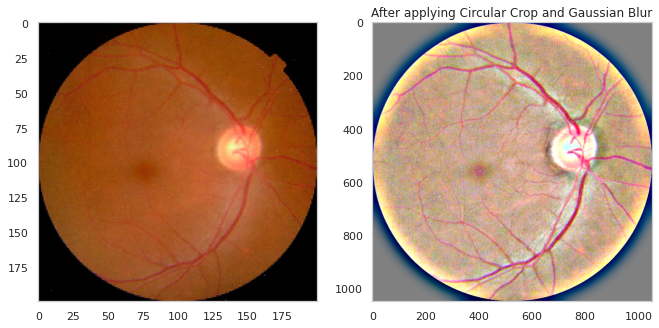

In [ ]:


rn = np.random.randint(low = 0,high = len(df_train) - 1)

#img = img_t
img = cv2.imread(df_train.file_path.iloc[rn])
img_t = circle_crop(img,sigmaX = 30)

f, axarr = plt.subplots(1,2,figsize = (11,11))
axarr[0].imshow(cv2.resize(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),(IMG_SIZE,IMG_SIZE)))
axarr[1].imshow(img_t)
plt.title('After applying Circular Crop and Gaussian Blur')
plt.show()

In [ ]:



def visualize_img_process(df,pts_per_class,sigmaX):
    df = df.groupby('diagnosis',group_keys = False).apply(lambda df: df.sample(pts_per_class))
    df = df.reset_index(drop = True)
    
    plt.rcParams["axes.grid"] = False
    for pt in range(pts_per_class):
        f, axarr = plt.subplots(1,5,figsize = (15,15))
        axarr[0].set_ylabel("Sample Data Points")
        
        df_temp = df[df.index.isin([pt + (pts_per_class*0),pt + (pts_per_class*1), pt + (pts_per_class*2),pt + (pts_per_class*3),pt + (pts_per_class*4)])]
        for i in range(5):
            img = cv2.imread(df_temp.file_path.iloc[i])
            img = circle_crop(img,sigmaX)
            axarr[i].imshow(img)
            axarr[i].set_xlabel('Class '+str(df_temp.diagnosis.iloc[i]))

        plt.show()

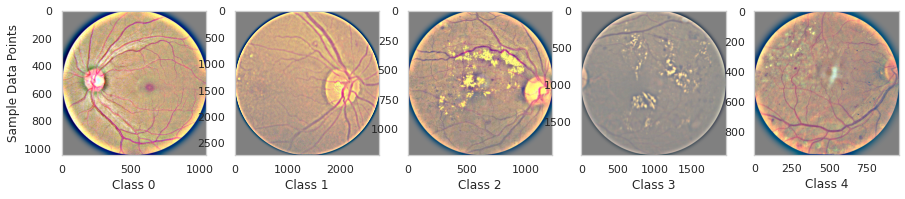

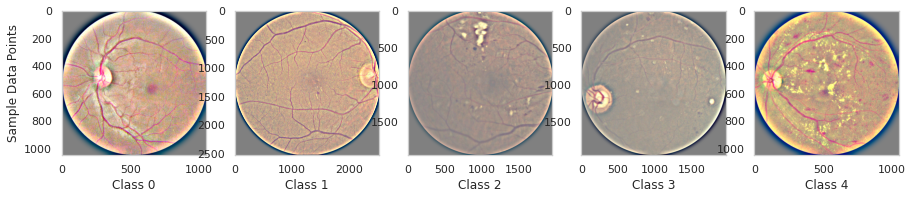

In [ ]:
visualize_img_process(df_train,2,sigmaX = 30)

In [ ]:
# train image data
npix = 224 # resize to npix x npix (for now)
X_train = np.zeros((df_train.shape[0], npix, npix))
for i in tqdm_notebook(range(df_train.shape[0])):
    # load an image
    img = cv2.imread(df_train.file_path.iloc[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    X_train[i, :, :] = cv2.resize(img, (npix, npix)) 
    
print("X_train shape: " + str(np.shape(X_train)))


X_train shape: (3662, 224, 224)


In [ ]:
# normalize
X = X_train / 255

# reshape
X = X.reshape(X.shape[0], -1)
trainy = df_train['diagnosis']

In [ ]:


def generate_augmentations(lim):
    datagen = ImageDataGenerator(featurewise_center=True,
                                 featurewise_std_normalization=True,
                                 rotation_range=20,
                                 #width_shift_range=0.2,
                                 #height_shift_range=0.2,
                                 horizontal_flip=True)
    img = cv2.imread(df_train.file_path.iloc[np.random.randint(low = 0,high = len(df_train) - 1)])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
    plt.imshow(img)
    plt.title('ORIGINAL IMAGE')
    plt.show()
    
    img_arr = img.reshape((1,) + img.shape)
    
    i = 0
    for img_iterator in datagen.flow(x = img_arr,batch_size = 1):
        i = i + 1
        if i > lim:
            break
        plt.imshow((img_iterator.reshape(img_arr[0].shape)).astype(np.uint8))
        plt.title('IMAGE AUGMENTATION ' + str(i))
        plt.show()

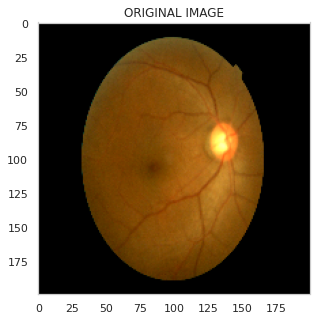

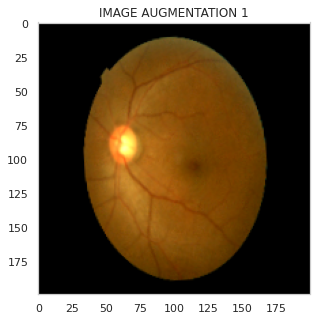

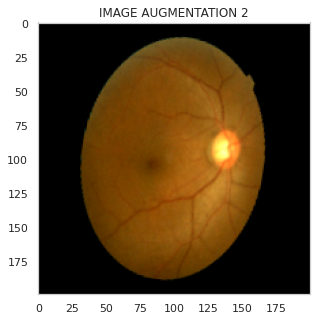

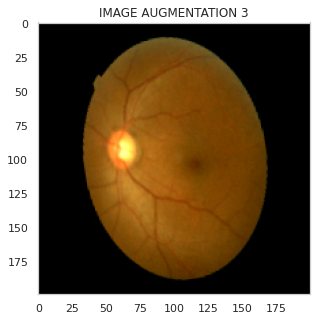

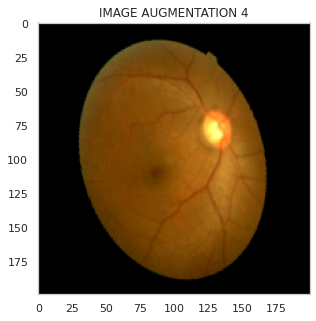

In [ ]:
generate_augmentations(4)

In [ ]:
df_train_train,df_train_test = train_test_split(df_train,test_size = 0.2)
print(df_train_train.shape,df_train_test.shape)

(2929, 4) (733, 4)


In [ ]:


def plot_classes(df,title):
    df_group = pd.DataFrame(df.groupby('diagnosis').agg('size').reset_index())
    df_group.columns = ['diagnosis','count']

    sns.set(rc={'figure.figsize':(10,5)}, style = 'whitegrid')
    sns.barplot(x = 'diagnosis',y='count',data = df_group,palette = "Blues_d")
    plt.title('Output Class Distribution ' + str(title))
    plt.show()

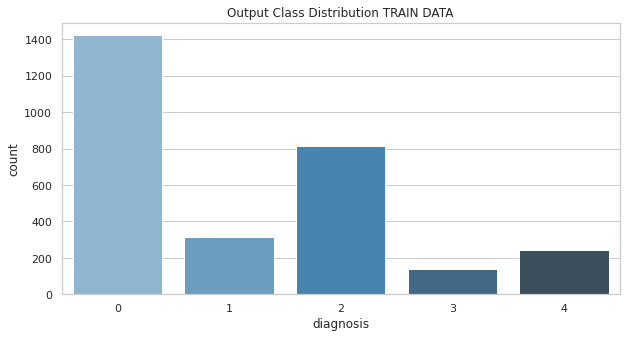

In [ ]:
plot_classes(df_train_train,"TRAIN DATA")

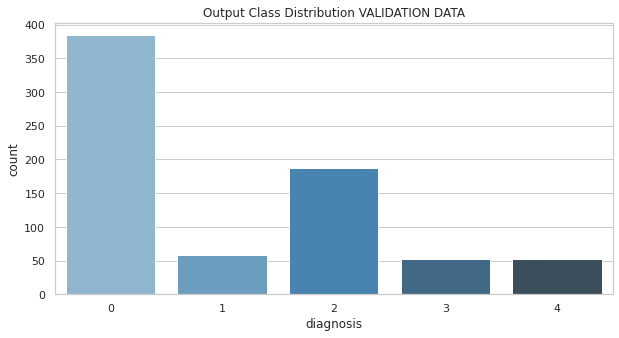

In [ ]:
plot_classes(df_train_test,'VALIDATION DATA')

In [ ]:

file = open('df_train_train', 'wb')
pickle.dump(df_train_train, file)
file.close()

file = open('df_train_test', 'wb')
pickle.dump(df_train_test, file)
file.close()


In [ ]:
file = open('df_train_train', 'rb')
df_train_train = pickle.load(file)
file.close()

file = open('df_train_test', 'rb')
df_train_test = pickle.load(file)
file.close()

In [ ]:
print(df_train_train.shape,df_train_test.shape)
#print(len(os.listdir('./train_images_resized_preprocessed')),len(os.listdir('./test_images_resized_preprocessed')))

(2929, 4) (733, 4)


Train_train images resized

In [ ]:
IMG_SIZE  = 512

In [ ]:


def image_resize_save(file):
    input_filepath = os.path.join('./','/content/drive/MyDrive/train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','/content/drive/MyDrive/train_train_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))
#image_resize_save(df_train.id_code.iloc[201])

In [ ]:



def multiprocess_image_downloader(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save, imgs)
    return results

In [ ]:
# Use 6 cores
multiprocess_image_downloader(6, list(df_train_train.id_code.values))

Train_test_images folder


In [ ]:


def image_resize_save1(file):
    input_filepath = os.path.join('./','/content/drive/MyDrive/train_images','{}.png'.format(file))
    output_filepath = os.path.join('./','/content/drive/MyDrive/train_test_images_resized','{}.png'.format(file))
    img = cv2.imread(input_filepath)
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))




def multiprocess_image_downloader1(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(image_resize_save1, imgs)
    return results


# Use 6 cores
multiprocess_image_downloader1(6, list(df_train_test.id_code.values))

Train_train_images_resized_preprocessed

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
    
    
    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','/content/drive/MyDrive/train_train_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','/content/drive/MyDrive/train_train_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))




def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results



# Use 6 cores
multiprocess_image_processor(2, list(df_train_train.id_code.values))

Train_test_images_resized_preprocessed

In [ ]:
def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
    #         print(img1.shape,img2.shape,img3.shape)
            img = np.stack([img1,img2,img3],axis=-1)
    #         print(img.shape)
        return img

def circle_crop(img, sigmaX = 30):   
        

    img = crop_image_from_gray(img)    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    height, width, depth = img.shape    
    
    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))
    
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    img=cv2.addWeighted(img,4, cv2.GaussianBlur( img , (0,0) , sigmaX) ,-4 ,128)
    return img 

def preprocess_image(file):
    input_filepath = os.path.join('./','/content/drive/MyDrive/train_test_images_resized','{}.png'.format(file))
    output_filepath = os.path.join('./','/content/drive/MyDrive/train_test_images_resized_preprocessed','{}.png'.format(file))
    
    img = cv2.imread(input_filepath)
    img = circle_crop(img) 
    cv2.imwrite(output_filepath, cv2.resize(img, (IMG_SIZE,IMG_SIZE)))



def multiprocess_image_processor(process:int, imgs:list):
    """
    Inputs:
        process: (int) number of process to run
        imgs:(list) list of images
    """
    print(f'MESSAGE: Running {process} process')
    results = ThreadPool(process).map(preprocess_image, imgs)
    return results



# Use 2 cores (colab)
multiprocess_image_processor(2, list(df_train_test.id_code.values))

#Training the model

In [ ]:
import pandas as pd
import numpy as np
import os
from prettytable import PrettyTable
import pickle
import multiprocessing
from multiprocessing.pool import ThreadPool
print(multiprocessing.cpu_count()," CPU cores")

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False

from sklearn.metrics import confusion_matrix, cohen_kappa_score,accuracy_score

from PIL import Image
import cv2

import keras
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers,Model,Sequential
from keras.layers import Input,GlobalAveragePooling2D,Dropout,Dense,Activation
#from keras.callbacks.callbacks import EarlyStopping,ReduceLROnPlateau

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

2  CPU cores


In [ ]:

BATCH_SIZE = 8
EPOCHS = 40
WARMUP_EPOCHS = 2
LEARNING_RATE = 1e-4
WARMUP_LEARNING_RATE = 1e-3
HEIGHT = 320
WIDTH = 320
CANAL = 3
N_CLASSES = df_train_train['diagnosis'].nunique()
ES_PATIENCE = 5
RLROP_PATIENCE = 3
DECAY_DROP = 0.5

In [ ]:
def img_generator(train,test):
    train_datagen=ImageDataGenerator(rescale=1./255, validation_split=0.2,horizontal_flip=True)
    
    train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="/content/drive/MyDrive/train_train_images_resized_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='training')
    
    valid_generator=train_datagen.flow_from_dataframe(dataframe=df_train_train,
                                                      directory="/content/drive/MyDrive/train_train_images_resized_preprocessed",
                                                      x_col="file_name",
                                                      y_col="diagnosis",
                                                      batch_size=BATCH_SIZE,
                                                      class_mode="categorical",    
                                                      target_size=(HEIGHT, WIDTH),
                                                      subset='validation')
    
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_dataframe(dataframe=df_train_test,
                                                      directory = "/content/drive/MyDrive/train_test_images_resized_preprocessed",
                                                      x_col="file_name",
                                                      target_size=(HEIGHT, WIDTH),
                                                      batch_size=1,
                                                      shuffle=False,
                                                      class_mode=None)
    
    return train_generator,valid_generator,test_generator


In [ ]:
train_generator,valid_generator,test_generator = img_generator(df_train_train,df_train_test)

Found 1882 validated image filenames belonging to 5 classes.
Found 470 validated image filenames belonging to 5 classes.
Found 156 validated image filenames.


In [ ]:
def create_model(input_shape, n_out):
    input_tensor = Input(shape=input_shape)
    base_model = applications.ResNet50(weights='imagenet', include_top=False,input_tensor=input_tensor)
    #base_model.load_weights('/content/drive/MyDrive/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',by_name=True)

    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(2048, activation='relu')(x)
    x = Dropout(0.5)(x)
    final_output = Dense(n_out, activation='softmax', name='final_output')(x)
    model = Model(input_tensor, final_output)
    return model

In [ ]:
model = create_model(input_shape=(HEIGHT, WIDTH, CANAL), n_out=N_CLASSES)

for layer in model.layers:
    layer.trainable = False

for i in range(-5, 0):
    model.layers[i].trainable = True
model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
_____________________________

In [ ]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print(STEP_SIZE_TRAIN,STEP_SIZE_VALID)

235 58


In [ ]:
model.compile(optimizer = optimizers.Adam(lr=WARMUP_LEARNING_RATE),loss = 'categorical_crossentropy',metrics = ['accuracy'])

history_warmup = model.fit_generator(generator=train_generator,
                                     steps_per_epoch=STEP_SIZE_TRAIN,
                                     validation_data=valid_generator,validation_steps=STEP_SIZE_VALID,
                                     epochs=WARMUP_EPOCHS,
                                     verbose=1).history

Epoch 1/2
235/235 [==============================] - 1155s 5s/step - loss: 2.5314 - accuracy: 0.3765 - val_loss: 1.3957 - val_accuracy: 0.4978
Epoch 2/2
235/235 [==============================] - 184s 784ms/step - loss: 1.4792 - accuracy: 0.4218 - val_loss: 1.2720 - val_accuracy: 0.5043


In [ ]:
for layer in model.layers:
    layer.trainable = True

es = EarlyStopping(monitor='val_loss', mode='min', patience=ES_PATIENCE, restore_best_weights=True, verbose=1)
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience=RLROP_PATIENCE, factor=DECAY_DROP, min_lr=1e-6, verbose=1)

callback_list = [es, rlrop]
optimizer = optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 320, 320, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 160, 160, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
history_finetunning = model.fit_generator(generator=train_generator,
                                          steps_per_epoch=STEP_SIZE_TRAIN,
                                          validation_data=valid_generator,
                                          validation_steps=STEP_SIZE_VALID,
                                          epochs=EPOCHS,
                                          callbacks=callback_list,
                                          verbose=1).history

Epoch 1/40
235/235 [==============================] - 58s 225ms/step - loss: 0.5794 - accuracy: 0.6035 - val_loss: 1.0858 - val_accuracy: 0.5043
Epoch 2/40
235/235 [==============================] - 51s 215ms/step - loss: 0.2434 - accuracy: 0.7279 - val_loss: 0.4910 - val_accuracy: 0.5086
Epoch 3/40
235/235 [==============================] - 51s 215ms/step - loss: 0.2094 - accuracy: 0.7709 - val_loss: 0.5378 - val_accuracy: 0.4978
Epoch 4/40
235/235 [==============================] - 51s 215ms/step - loss: 0.1796 - accuracy: 0.8137 - val_loss: 0.2502 - val_accuracy: 0.7306
Epoch 5/40
235/235 [==============================] - 51s 215ms/step - loss: 0.1797 - accuracy: 0.8109 - val_loss: 0.1956 - val_accuracy: 0.8147
Epoch 6/40
235/235 [==============================] - 51s 216ms/step - loss: 0.1500 - accuracy: 0.8498 - val_loss: 0.3056 - val_accuracy: 0.7888
Epoch 7/40
235/235 [==============================] - 51s 215ms/step - loss: 0.1332 - accuracy: 0.8556 - val_loss: 0.3339 - val_ac

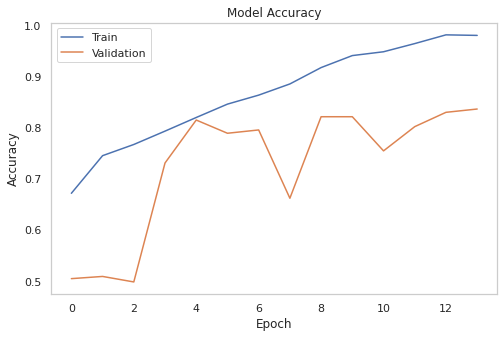

In [ ]:
plt.figure(figsize=(8,5))

plt.plot(history_finetunning['accuracy'])
plt.plot(history_finetunning['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.gca().ticklabel_format(axis='both', style='plain', useOffset=False)
plt.show()